<a href="https://colab.research.google.com/github/adharv49/project/blob/main/Another_copy_of_IP_Inpainting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Virtual Try-On using IP-Adapters Inpainting

by [Tony Assi](https://www.tonyassi.com/)

Check out the [blog post](https://huggingface.co/blog/tonyassi/virtual-try-on-ip-adapter) for this notebook

---

*This notebook requires a GPU. Go to Runtime->Change Runtime Type and select a GPU:*

A100 ✅

V100 ✅

T4 ✅

CPU ❌

TPU ❌

---

![image/jpeg](https://cdn-uploads.huggingface.co/production/uploads/648a824a8ca6cf9857d1349c/r5JBiW4d1h_jK3Sy3NOOj.jpeg)

**Install libraries**

In [2]:
!pip install diffusers accelerate

**Import libraries**

In [3]:
from diffusers import AutoPipelineForInpainting, AutoencoderKL
from diffusers.utils import load_image
import torch

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [10]:
!nvidia-smi

Tue Dec 17 15:00:28 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   71C    P0              30W /  70W |  14867MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

**Load the pipeline**

In [4]:
vae = AutoencoderKL.from_pretrained("madebyollin/sdxl-vae-fp16-fix", torch_dtype=torch.float16)
pipeline = AutoPipelineForInpainting.from_pretrained("diffusers/stable-diffusion-xl-1.0-inpainting-0.1", vae=vae, torch_dtype=torch.float16, variant="fp16", use_safetensors=True).to("cuda")
pipeline.load_ip_adapter("h94/IP-Adapter", subfolder="sdxl_models", weight_name="ip-adapter_sdxl.bin", low_cpu_mem_usage=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/631 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

model_index.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

text_encoder_2/config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.93k [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The config attributes {'decay': 0.9999, 'inv_gamma': 1.0, 'min_decay': 0.0, 'optimization_step': 37000, 'power': 0.6666666666666666, 'update_after_step': 0, 'use_ema_warmup': False} were passed to UNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.


ip-adapter_sdxl.bin:   0%|          | 0.00/703M [00:00<?, ?B/s]

sdxl_models/image_encoder/config.json:   0%|          | 0.00/2.01k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.69G [00:00<?, ?B/s]

**Load the main image**

**Load the clothing image**

**Create the mask image**

To create the mask image we're going to use a [body segmentation tool](https://github.com/TonyAssi/Segment-Body) that will do it automatically

**Generate image**

**Virtual Try-On Function**

Now lets put it all together into a function so that all you need to do is pass the image and the clothing

In [ ]:
def virtual_try_on(img, clothing, prompt, negative_prompt, ip_scale=1.0, strength=0.99, guidance_scale=7.5, steps=100):
    _, mask_img = segment_body(img, face=False)
    pipeline.set_ip_adapter_scale(ip_scale)
    images = pipeline(
        prompt=prompt,
        negative_prompt=negative_prompt,
        image=img,
        mask_image=mask_img,
        ip_adapter_image=clothing,
        strength=strength,
        guidance_scale=guidance_scale,
        num_inference_steps=steps,
    ).images
    return images[0]

In [ ]:
image = load_image('/content/temp_model.jpg').convert("RGB")
ip_image = load_image('/content/temp_cloth.jpg').convert("RGB")

/usr/local/lib/python3.10/dist-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


  0%|          | 0/99 [00:00<?, ?it/s]

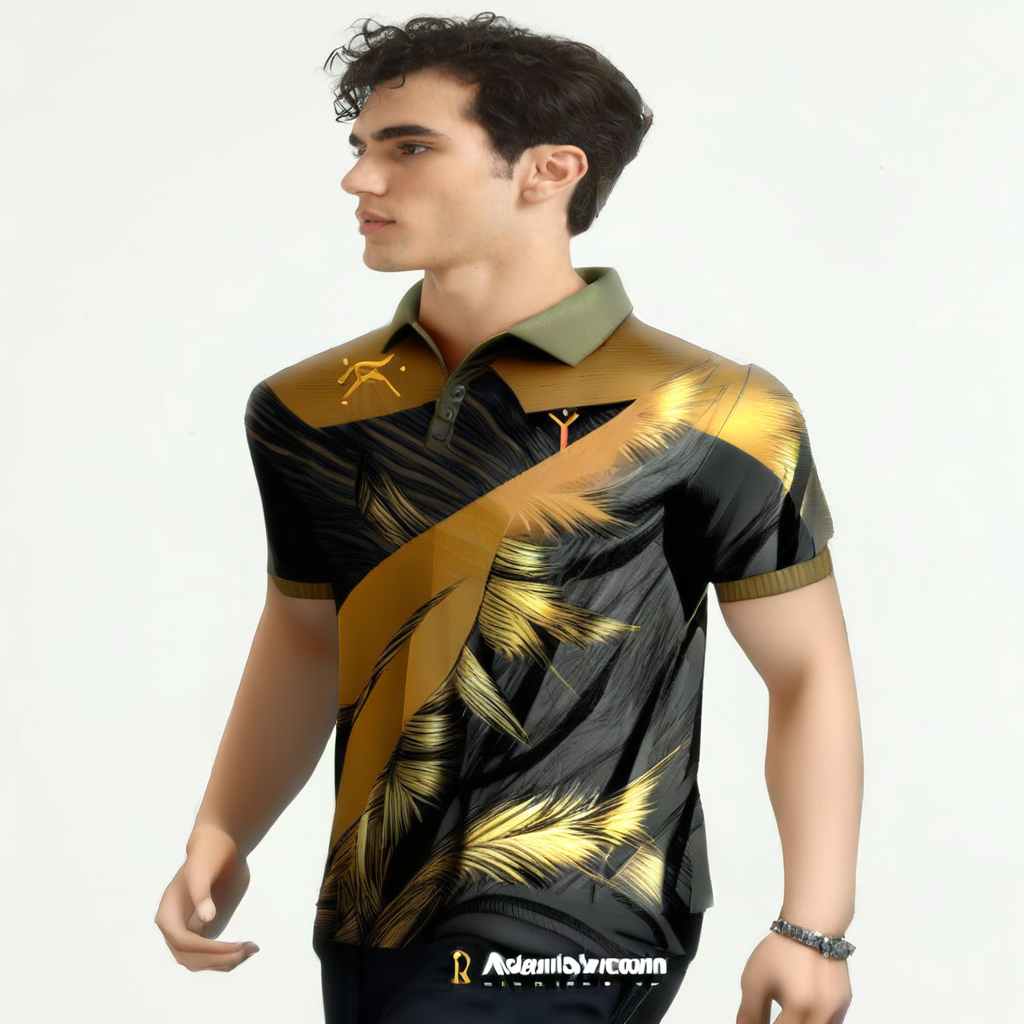

In [ ]:
virtual_try_on(img=image,
               clothing=ip_image,
               prompt="photorealistic, perfect body, beautiful skin, realistic skin, natural skin",
               negative_prompt="ugly, bad quality, bad anatomy, deformed body, deformed hands, deformed feet, deformed face, deformed clothing, deformed skin, bad skin, leggings, tights, stockings")

In [5]:
!pip install albumentations
!pip install iglovikov-helper-functions
!pip install cloths_segmentation

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.5/64.5 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 43.0 MB/s eta 0:00:00
  Created wheel for jpeg4py: filename=jpeg4py-0.1.4-py3-none-any.whl size=8422 sha256=934fd001f40ec0865a735957b3576ad8e8b6071548b016c3823034ffd42c1713
  Stored in directory: /root/.cache/pip/wheels/86/c3/0f/348e6cadb3a27435e833d21d91707d653fb159d69f2a867a36
Successfully built jpeg4py
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 170.1/170.1 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [6]:
!pip install onnxruntime
!pip install gradio
!pip install insightface

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 98.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.4/320.4 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.6 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.5/439.5 kB 8.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 30.6 MB/s eta 0:00:00
  Created wheel for insightface: filename=insightface-0.7.3-cp310-cp310-linux_x86_64.whl size=1055379 sha256=819cd2cf5abe5338a8f18c9c2e6f0d29a672345fde756f17f638fd0bf2859232
  Stored in directory: /root/.cache/pip/wheels/e3/d0/80/e3773fb8b6d1cca87ea1d33d9b1f20a223a6493c896da249b5
Successfully built insightface


In [ ]:
!ls

__pycache__  sample_data  SegBody.py  Segment-Body  temp_cloth.jpg  temp_model.jpg


In [7]:
from SegBody import segment_body
from diffusers.utils import load_image
import numpy as np
import cv2
import torch
import albumentations as albu
from PIL import Image
from iglovikov_helper_functions.utils.image_utils import load_rgb, pad, unpad
from iglovikov_helper_functions.dl.pytorch.utils import tensor_from_rgb_image
#from cloths_segmentation.pre_trained_models import create_model
from diffusers import AutoencoderKL,AutoPipelineForInpainting

def generate_masked_image(cloth_path, model_path):
    cloth_image = load_image(cloth_path).convert("RGB")
    cloth_image.resize((512, 512))
    model_image = load_image(model_path).convert("RGB")
    model_image.resize((512, 512))
    seg_image, mask_image = segment_body(model_path, face=False)
    mask_image.resize((512, 512))
    pipeline.set_ip_adapter_scale(1.0)
    images = pipeline(
    prompt="photorealistic, perfect body, beautiful skin, realistic skin, natural skin",
    negative_prompt="ugly, bad quality, bad anatomy, deformed body, deformed hands, deformed feet, deformed face, deformed clothing, deformed skin, bad skin, leggings, tights, stockings",
    image=model_image,
    mask_image=mask_image,
    ip_adapter_image=cloth_image,
    strength=0.99,
    guidance_scale=7.5,
    num_inference_steps=100,
    ).images
    return images[0]

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.22 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


download_path: /root/.insightface/models/buffalo_l


100%|██████████| 281857/281857 [00:06<00:00, 40593.94KB/s]
/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)


config.json:   0%|          | 0.00/1.73k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/109M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/271 [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


In [8]:
import gradio as gr
from PIL import Image
#from IPtry import generate_masked_image
def run(cloth, model):
    # Resize the cloth image to fit on the model (adjust size as necessary)
    #cloth_resized = cloth.resize((model.width, int(model.height / 2)))  # Example: scale cloth to half the model height

    # Position the cloth overlay (you may adjust positioning for a better fit)
    #position = (0, model.height - cloth_resized.height)  # Places cloth at the bottom of the model

    # Create a copy of the model to avoid altering the original
    #result = model.copy()

    # Overlay the cloth onto the model
    #result.paste(cloth_resized, position)# cloth_resized)  # The third parameter handles transparency if available

    #return result
    cloth.save("temp_cloth.jpg")
    model.save("temp_model.jpg")

    # Call the masking function from mask.py
    masked_image = generate_masked_image("temp_cloth.jpg", "temp_model.jpg")

    # Return the masked image for display
    return masked_image
with gr.Blocks() as app:
    with gr.Row():
        gr.Markdown("<center><h1> DIGIDRAPE </h1><center>")
    with gr.Row():
        with gr.Column():
            cloth_input = gr.Image(sources=['upload'], type="pil", label="Upload the Cloth Image")
        with gr.Column():
            model_input = gr.Image(sources=['upload'], type="pil", label="Upload the Human Image")
    with gr.Row():
        final_output = gr.Image(sources=['upload'], type="pil", label="Final Prediction")
    with gr.Row():
        submit_button = gr.Button("Submit")

    submit_button.click(fn=run, inputs=[cloth_input, model_input],
                        outputs=[final_output])
app.launch(debug=True, share=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://52c51014563b40e63f.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


/usr/local/lib/python3.10/dist-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


  0%|          | 0/99 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


  0%|          | 0/99 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


  0%|          | 0/99 [00:00<?, ?it/s]

Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://52c51014563b40e63f.gradio.live
